# EGTA Framework Exploration

This notebook demonstrates how to use the Empirical Game-Theoretic Analysis (EGTA) framework to explore strategic interactions between agents deciding how to allocate their trading between traditional CDA markets and the MELO mechanism.

## Overview

1. Basic EGTA setup and running experiments
2. Analyzing equilibria and visualizing results
3. Parameter sweeps to understand how market conditions affect strategy selection
4. Advanced techniques for exploring larger strategy spaces

## 1. Setup and Imports

In [1]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, List, Tuple, Any, Optional
from tqdm.notebook import tqdm
import fix_path
import widgetsnbextension

"""
Example code to fix import issues in the egta_exploration.ipynb notebook.

Copy the following code to the first cell of your notebook to fix
the 'No module named marketsim' error.
"""
import os
import sys
import json

# FIX PATH CONFIGURATION: Add the project root to Python path
notebook_dir = os.getcwd()  # Current working directory

# Check if we're in the examples directory
if notebook_dir.endswith('examples'):
    # We're in the examples directory, so parent is project root
    project_root = os.path.dirname(notebook_dir)
else:
    # Find the project root by looking for marketsim directory
    project_root = notebook_dir
    while not os.path.exists(os.path.join(project_root, 'marketsim')) and project_root != '/':
        project_root = os.path.dirname(project_root)
        
    if not os.path.exists(os.path.join(project_root, 'marketsim')):
        # Fallback - try parent of current directory
        project_root = os.path.dirname(notebook_dir)

# Add project root to Python path
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added {project_root} to Python path")
else:
    print(f"{project_root} already in Python path")

# Debug information
print(f"Current working directory: {notebook_dir}")
print(f"Project root directory: {project_root}")
print(f"sys.path: {sys.path[0]}")

# Try importing fix_path as a fallback
try:
    import fix_path
    fix_path.add_project_root_to_path()
except ImportError:
    print("Could not import fix_path module, using direct path configuration")

# Now test if marketsim can be imported
try:
    import marketsim
    print("Successfully imported marketsim module")
except ImportError as e:
    print(f"Error importing marketsim: {e}")
    print("Please make sure marketsim is installed or the path is correctly set")

# Rest of your imports should work now
from marketsim.egta.egta import EGTA
from marketsim.egta.simulators.melo_wrapper import MeloSimulator
from marketsim.egta.schedulers.dpr import DPRScheduler
from marketsim.egta.schedulers.random import RandomScheduler
from marketsim.egta.utils.visualization import (
    plot_equilibria, 
    plot_strategy_frequency, 
    plot_payoff_matrix,
    plot_regret_landscape,
    create_visualization_report
)
from marketsim.egta.core.game import Game
from marketsim.egta.solvers.equilibria import replicator_dynamics, quiesce, regret

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

Matplotlib created a temporary cache directory at /var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/matplotlib-l44gyr68 because the default path (/Users/gabesmithline/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Added /Users/gabesmithline/Desktop/SRG/melo_project to Python path
Current working directory: /Users/gabesmithline/Desktop/SRG/melo_project/examples
Project root directory: /Users/gabesmithline/Desktop/SRG/melo_project
sys.path: /Users/gabesmithline/Desktop/SRG/melo_project
/Users/gabesmithline/Desktop/SRG/melo_project already in Python path
Successfully imported marketsim module


In [2]:
!jupyter nbextension enable --py widgetsnbextension


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console contrib dejavu events execute kernel kernelspec
lab labextension labhub migrate nbconvert nbextensions_configurator notebook
run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


## 2. Basic EGTA Experiment

Let's run a basic EGTA experiment to analyze how agents allocate trading between CDA and MELO markets.

In [3]:
# Create output directory
output_dir = 'results/egta_notebook'
os.makedirs(output_dir, exist_ok=True)

In [4]:
# Create MELO simulator with default parameters
simulator = MeloSimulator(
    num_strategic=10,  # Number of strategic MOBI agents
    sim_time=1000,   # Simulation time horizon
    lam=0.1,         # Arrival rate
    mean=100,        # Mean fundamental value
    r=0.05,          # Mean reversion rate
    q_max=10,        # Maximum inventory
    holding_period=1, # MELO holding period
    reps=100           # Number of simulation repetitions per profile
)

# Get available strategies
strategies = simulator.get_strategies()
print(f"Available strategies: {strategies}")

# Print strategy parameters
print("\nStrategy parameters:")
for strategy in strategies:
    params = simulator.strategy_params[strategy]
    print(f"  {strategy}: CDA={params['cda_proportion']:.2f}, MELO={params['melo_proportion']:.2f}")

Available strategies: ['MELO_100_0', 'MELO_0_100']

Strategy parameters:
  MELO_100_0: CDA=1.00, MELO=0.00
  MELO_0_100: CDA=0.00, MELO=1.00


In [5]:
# Create scheduler (using DPR for more efficient exploration)
scheduler = DPRScheduler(
    strategies=strategies,
    num_players=simulator.get_num_players(),
    subgame_size=min(4, len(strategies)),  # Subgame size for DPR
    batch_size=5,     # Profiles to simulate per iteration
    seed=42           # Random seed for reproducibility
)

# Create EGTA framework
egta = EGTA(
    simulator=simulator,
    scheduler=scheduler,
    device="cpu",     # Use CPU for computation
    output_dir=output_dir,
    max_profiles=2,   # Maximum number of profiles to simulate
    seed=42           # Random seed for reproducibility
)

In [6]:
# Run EGTA (this may take some time)
print("Starting EGTA experiment...")
print(f"Analyzing market allocation strategies: {strategies}")

game = egta.run(
    max_iterations=100,    # Maximum number of iterations
    profiles_per_iteration=2,  # Profiles to simulate per iteration
    save_frequency=1,    # Save results every iteration
    verbose=True         # Print progress information
)

print("\nEGTA experiment completed!")

Starting EGTA experiment...
Analyzing market allocation strategies: ['MELO_100_0', 'MELO_0_100']

Iteration 1/100
Simulating 2 profiles...
Simulating profile 1/2: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_0_100', 'MELO_0_100']


  0%|          | 0/100 [00:00<?, ?it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-63.0039])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-63.0039])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([259.1970])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([259.1970])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-302.0237])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-302.0237])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([618.2065])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Age

  1%|          | 1/100 [00:00<00:46,  2.13it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-49.8117])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-49.8117])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-197.4395])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-197.4395])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-37.7401])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-37.7401])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([228.1422])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Age

  2%|▏         | 2/100 [00:00<00:45,  2.16it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([858.6826])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([858.6826])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-2168.4934])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-2168.4934])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1038.7070])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([1038.7070])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-1331.4324])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trad

  3%|▎         | 3/100 [00:01<00:47,  2.04it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([107.2967])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([107.2967])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-325.3120])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-325.3120])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1096.5701])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([1096.5701])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([589.1855])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: A

  4%|▍         | 4/100 [00:02<00:53,  1.79it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-1813.3264])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-1813.3264])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([690.8849])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([690.8849])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-420.2137])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-420.2137])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([192.5858])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade:

  5%|▌         | 5/100 [00:02<00:50,  1.90it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1026.2378])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([1026.2378])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-45.9976])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-45.9976])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price 1298.3526965837073
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price 1298.3526965837073
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-769.7423])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Ag

  6%|▌         | 6/100 [00:03<00:47,  1.97it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-673.4232])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-673.4232])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-1788.1211])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-1788.1211])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-161.2831])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-161.2831])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-2513.3560])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Tr

  7%|▋         | 7/100 [00:03<00:46,  2.02it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-60.0593])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-60.0593])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([210.5733])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([210.5733])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([388.2438])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([388.2438])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-990.9505])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agen

  8%|▊         | 8/100 [00:04<00:46,  1.99it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-1802.2765])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-1802.2765])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price 256.7330898256324
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price 256.7330898256324
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([246.8519])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([246.8519])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price 36.92717375740952
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agen

  9%|▉         | 9/100 [00:04<00:45,  2.01it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-214.1697])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-214.1697])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price 149.31630575858247
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price 149.31630575858247
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([869.1768])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([869.1768])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([363.6152])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Age

 10%|█         | 10/100 [00:05<00:45,  1.99it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-1453.2347])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-1453.2347])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-597.6713])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-597.6713])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-408.8468])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-408.8468])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1140.6003])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Tra

 11%|█         | 11/100 [00:05<00:44,  2.02it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([288.1432])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([288.1432])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-151.4013])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-151.4013])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([24.5886])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([24.5886])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price 53.60633323790637
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 

 12%|█▏        | 12/100 [00:06<00:44,  1.98it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([409.4304])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([409.4304])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price 322.2024880171189
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price 322.2024880171189
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([743.6333])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([743.6333])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1845.9910])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 

 13%|█▎        | 13/100 [00:06<00:43,  2.02it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-320.5605])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-320.5605])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-530.5223])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-530.5223])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-96.8890])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-96.8890])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-82.0364])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: A

 14%|█▍        | 14/100 [00:06<00:41,  2.07it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([504.9139])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([504.9139])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([420.9014])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([420.9014])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([315.5989])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([315.5989])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1847.1803])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agen

 15%|█▌        | 15/100 [00:07<00:40,  2.10it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-769.4773])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-769.4773])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([342.2849])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([342.2849])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1080.8026])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([1080.8026])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([420.2894])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: A

 16%|█▌        | 16/100 [00:07<00:40,  2.06it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1812.9592])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([1812.9592])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-1761.4835])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-1761.4835])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-896.2132])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-896.2132])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1377.4785])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Tra

 17%|█▋        | 17/100 [00:08<00:39,  2.09it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1182.1840])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([1182.1840])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-279.8368])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-279.8368])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([2902.8794])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([2902.8794])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-49.0214])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade:

 18%|█▊        | 18/100 [00:08<00:39,  2.10it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-44.9331])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-44.9331])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price -948.4165188697411
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price -948.4165188697411
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-178.1473])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-178.1473])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([32.5268])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agen

 19%|█▉        | 19/100 [00:09<00:43,  1.87it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price 739.4090899285367
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price 739.4090899285367
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-1015.7906])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-1015.7906])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([128.9840])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([128.9840])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1258.8770])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Ag

 20%|██        | 20/100 [00:10<00:42,  1.86it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-16.0511])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-16.0511])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1199.5176])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([1199.5176])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-26.8860])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-26.8860])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-173.0338])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Ag

 21%|██        | 21/100 [00:11<00:54,  1.45it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([489.5267])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([489.5267])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-455.6181])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-455.6181])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([7.4340])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([7.4340])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price -446.38981970930047
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 

 22%|██▏       | 22/100 [00:11<00:50,  1.54it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1026.3409])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([1026.3409])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-305.7075])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-305.7075])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-383.9972])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-383.9972])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([670.7462])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade:

 23%|██▎       | 23/100 [00:12<00:48,  1.57it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1073.1899])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([1073.1899])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price -888.2215624858859
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price -888.2215624858859
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([704.4443])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([704.4443])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([566.3995])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Age

 24%|██▍       | 24/100 [00:12<00:49,  1.54it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price -607.245791960248
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price -607.245791960248
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-1316.7080])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-1316.7080])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-1475.0077])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-1475.0077])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-293.0884])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade

 25%|██▌       | 25/100 [00:13<00:46,  1.63it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([615.7809])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([615.7809])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-332.8236])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-332.8236])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-241.0337])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-241.0337])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1152.4580])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: 

 26%|██▌       | 26/100 [00:14<00:42,  1.73it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-213.6133])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-213.6133])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price 566.1804769705049
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price 566.1804769705049
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([376.3830])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([376.3830])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0


 27%|██▋       | 27/100 [00:14<00:39,  1.83it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([650.1413])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([650.1413])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1198.6764])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([1198.6764])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1330.8525])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([1330.8525])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price -91.4990554978398
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Ag

 28%|██▊       | 28/100 [00:15<00:38,  1.86it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([531.5353])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([531.5353])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1220.8181])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([1220.8181])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1667.1305])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([1667.1305])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([928.9386])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: A

 29%|██▉       | 29/100 [00:15<00:36,  1.93it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-259.4463])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-259.4463])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-32.2347])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-32.2347])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([721.9326])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([721.9326])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-22.9257])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Age

 30%|███       | 30/100 [00:16<00:36,  1.92it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-1377.5553])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-1377.5553])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-452.3093])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-452.3093])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([652.1984])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([652.1984])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([622.0389])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade:

 31%|███       | 31/100 [00:16<00:34,  1.98it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-533.5686])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-533.5686])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([890.3934])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([890.3934])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-434.5836])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-434.5836])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price 699.9211998206202
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Ag

 32%|███▏      | 32/100 [00:16<00:34,  1.97it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price -142.14705218406425
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price -142.14705218406425
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price 1302.745354294123
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price 1302.745354294123
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-707.3433])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-707.3433])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-910.7290])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Ag

 33%|███▎      | 33/100 [00:17<00:33,  2.02it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1003.4120])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([1003.4120])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([453.9217])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([453.9217])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-666.2403])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-666.2403])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-2083.5356])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade:

 34%|███▍      | 34/100 [00:17<00:32,  2.05it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([353.6859])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([353.6859])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([227.9202])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([227.9202])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([84.0235])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([84.0235])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-489.6365])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 

 35%|███▌      | 35/100 [00:18<00:32,  2.01it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-77.3541])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-77.3541])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-442.0984])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-442.0984])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-779.3271])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-779.3271])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-238.4203])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: 

 36%|███▌      | 36/100 [00:18<00:32,  1.98it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([608.8971])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([608.8971])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-154.8864])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-154.8864])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-400.6178])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-400.6178])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-712.4545])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: 

 37%|███▋      | 37/100 [00:19<00:30,  2.04it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1046.5972])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([1046.5972])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([144.3869])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([144.3869])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-900.0051])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-900.0051])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-1078.1973])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade:

 38%|███▊      | 38/100 [00:19<00:30,  2.07it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-2741.0603])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-2741.0603])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([176.1993])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([176.1993])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-26.6412])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-26.6412])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-51.9644])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: A

 39%|███▉      | 39/100 [00:20<00:29,  2.07it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price 293.77102451676035
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price 293.77102451676035
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([952.4064])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([952.4064])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-334.6894])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-334.6894])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-462.3702])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Ag

 40%|████      | 40/100 [00:20<00:29,  2.02it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price -1200.6359503962158
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price -1200.6359503962158
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-642.6987])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-642.6987])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price 335.63592029765874
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price 335.63592029765874
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price 915.7765801905088
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Ag

 41%|████      | 41/100 [00:21<00:29,  2.03it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price 416.8444609363098
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price 416.8444609363098
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([14.8301])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([14.8301])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1313.8180])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([1313.8180])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price 62.816129337165705
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 2

 42%|████▏     | 42/100 [00:21<00:28,  2.05it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([78.1266])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([78.1266])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1864.8191])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([1864.8191])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-103.9117])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-103.9117])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-604.5513])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Ag

 43%|████▎     | 43/100 [00:22<00:28,  2.03it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-130.1909])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-130.1909])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-364.0690])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-364.0690])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-1009.9043])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-1009.9043])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price -60.328784799951165
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Tra

 44%|████▍     | 44/100 [00:22<00:29,  1.89it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-1019.1686])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-1019.1686])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-1819.4102])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-1819.4102])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1439.0903])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([1439.0903])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-1071.0247])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO 

 45%|████▌     | 45/100 [00:23<00:27,  1.97it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-204.0268])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-204.0268])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price 309.7616315602103
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price 309.7616315602103
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([814.7126])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([814.7126])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([981.5549])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent

 46%|████▌     | 46/100 [00:23<00:27,  1.97it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([950.8076])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([950.8076])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-101.4777])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-101.4777])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1314.7312])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([1314.7312])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1619.5309])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: 

 47%|████▋     | 47/100 [00:24<00:26,  2.01it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([580.7903])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([580.7903])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price -180.1981576869831
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price -180.1981576869831
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([2081.6404])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([2081.6404])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([45.9578])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agen

 48%|████▊     | 48/100 [00:24<00:26,  1.95it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1804.8754])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([1804.8754])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([192.4169])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([192.4169])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([817.3203])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([817.3203])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1459.0428])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Ag

 49%|████▉     | 49/100 [00:25<00:25,  1.99it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-924.8228])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-924.8228])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price -159.63395026999012
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price -159.63395026999012
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([728.0709])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([728.0709])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([2026.8057])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: 

 50%|█████     | 50/100 [00:25<00:24,  2.03it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([282.3763])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([282.3763])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([598.3727])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([598.3727])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-653.3885])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-653.3885])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([995.0646])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Age

 51%|█████     | 51/100 [00:26<00:24,  1.99it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price -781.6435646602216
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price -781.6435646602216
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-764.3649])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-764.3649])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1057.6810])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([1057.6810])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([625.2886])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: A

 52%|█████▏    | 52/100 [00:26<00:24,  1.98it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([2498.9268])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([2498.9268])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-1129.0396])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-1129.0396])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([353.6562])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([353.6562])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([347.5895])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade:

 53%|█████▎    | 53/100 [00:27<00:23,  1.97it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-2347.8237])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-2347.8237])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-301.7393])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-301.7393])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-1113.7153])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-1113.7153])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([180.6746])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Tr

 54%|█████▍    | 54/100 [00:27<00:22,  2.03it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price 766.4796122611026
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price 766.4796122611026
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1065.3992])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([1065.3992])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price 848.9364978646548
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price 848.9364978646548
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price 851.9625691175094
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24

 55%|█████▌    | 55/100 [00:28<00:22,  2.00it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-919.8777])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-919.8777])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-373.0268])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-373.0268])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-84.9210])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-84.9210])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([726.8972])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: A

 56%|█████▌    | 56/100 [00:29<00:24,  1.81it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-708.5146])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-708.5146])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1159.8259])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([1159.8259])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([795.7812])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([795.7812])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-34.1288])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: A

 57%|█████▋    | 57/100 [00:29<00:22,  1.91it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([2762.8960])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([2762.8960])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([527.7875])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([527.7875])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([743.0231])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([743.0231])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price 553.6669373116084
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agen

 58%|█████▊    | 58/100 [00:30<00:22,  1.85it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([210.1416])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([210.1416])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price -712.3072027904817
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price -712.3072027904817
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-326.6041])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-326.6041])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([626.3232])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Age

 59%|█████▉    | 59/100 [00:30<00:23,  1.78it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-454.6776])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-454.6776])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([414.5331])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([414.5331])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([504.7544])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([504.7544])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([303.8571])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Age

 60%|██████    | 60/100 [00:31<00:21,  1.83it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-268.0997])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-268.0997])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-271.2261])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-271.2261])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([458.6835])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([458.6835])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([53.7054])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Ag

 61%|██████    | 61/100 [00:31<00:20,  1.89it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-102.1136])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-102.1136])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-606.1590])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-606.1590])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price -106.40437198416129
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price -106.40437198416129
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([774.1177])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade:

 62%|██████▏   | 62/100 [00:32<00:19,  1.94it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-244.1219])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-244.1219])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-453.4068])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-453.4068])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price 1308.769598771521
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price 1308.769598771521
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([690.3115])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Age

 63%|██████▎   | 63/100 [00:32<00:19,  1.92it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-104.4688])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-104.4688])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([267.4100])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([267.4100])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-434.0652])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-434.0652])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-1566.0183])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade:

 64%|██████▍   | 64/100 [00:33<00:18,  1.99it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-204.6669])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-204.6669])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([596.0004])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([596.0004])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-128.2542])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-128.2542])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([655.3925])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: A

 65%|██████▌   | 65/100 [00:33<00:17,  2.02it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1476.8668])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([1476.8668])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-493.2020])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-493.2020])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price 51.84020101739827
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price 51.84020101739827
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price -119.26953835988695
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Ag

 66%|██████▌   | 66/100 [00:34<00:16,  2.05it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price -247.5361416394961
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price -247.5361416394961
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([812.0408])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([812.0408])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1828.4928])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([1828.4928])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-356.8821])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Ag

 67%|██████▋   | 67/100 [00:34<00:16,  2.01it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([372.5908])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([372.5908])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1925.9236])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([1925.9236])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-297.8329])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-297.8329])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-1348.0654])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade:

 68%|██████▊   | 68/100 [00:35<00:15,  2.04it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([209.1938])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([209.1938])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-578.3635])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-578.3635])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([952.7494])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([952.7494])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([748.5712])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Age

 69%|██████▉   | 69/100 [00:35<00:15,  2.06it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-863.1385])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-863.1385])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1259.2881])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([1259.2881])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-357.9140])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-357.9140])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-60.9075])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade:

 70%|███████   | 70/100 [00:36<00:14,  2.07it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([139.0957])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([139.0957])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([405.4787])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([405.4787])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-11.3542])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-11.3542])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([38.8831])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 

 71%|███████   | 71/100 [00:36<00:14,  2.02it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([752.7693])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([752.7693])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-1354.6003])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-1354.6003])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([783.0912])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([783.0912])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-319.2353])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: 

 72%|███████▏  | 72/100 [00:37<00:13,  2.04it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-2397.5125])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-2397.5125])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([786.6810])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([786.6810])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1070.1425])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([1070.1425])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price -367.8344659884829
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade:

 73%|███████▎  | 73/100 [00:37<00:13,  1.97it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-590.9717])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-590.9717])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-59.2673])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-59.2673])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([689.6023])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([689.6023])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price 66.28009697771824
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agen

 74%|███████▍  | 74/100 [00:38<00:12,  2.01it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-893.5486])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-893.5486])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-813.0302])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-813.0302])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([510.2975])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([510.2975])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-277.6435])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: 

 75%|███████▌  | 75/100 [00:38<00:12,  1.98it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([537.7995])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([537.7995])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([712.8730])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([712.8730])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([452.9667])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([452.9667])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-757.4696])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agen

 76%|███████▌  | 76/100 [00:39<00:11,  2.02it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price -450.0525377356011
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price -450.0525377356011
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-1270.8579])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-1270.8579])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([700.6070])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([700.6070])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1087.3552])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: 

 77%|███████▋  | 77/100 [00:39<00:11,  2.04it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1686.2964])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([1686.2964])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price 324.3433044367957
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price 324.3433044367957
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price -350.2047646003549
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price -350.2047646003549
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([2040.8383])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agen

 78%|███████▊  | 78/100 [00:40<00:10,  2.06it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price 1365.3364622967256
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price 1365.3364622967256
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price -459.01679089677145
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price -459.01679089677145
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price -437.2631954889679
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price -437.2631954889679
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-238.6340])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Ag

 79%|███████▉  | 79/100 [00:40<00:10,  2.01it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price 1036.3393039770558
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price 1036.3393039770558
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([91.2720])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([91.2720])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([495.0669])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([495.0669])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-713.3280])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 

 80%|████████  | 80/100 [00:41<00:09,  2.04it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-478.8875])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-478.8875])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-954.8723])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-954.8723])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-873.8165])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-873.8165])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([2670.9465])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade

 81%|████████  | 81/100 [00:41<00:09,  2.06it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-334.0153])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-334.0153])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-715.8572])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-715.8572])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([606.0701])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([606.0701])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([990.6132])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: A

 82%|████████▏ | 82/100 [00:42<00:08,  2.09it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([835.9073])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([835.9073])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-164.3336])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-164.3336])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-510.1246])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-510.1246])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([501.6093])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: A

 83%|████████▎ | 83/100 [00:42<00:08,  2.03it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-171.6400])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-171.6400])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-805.3669])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-805.3669])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([419.7865])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([419.7865])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([750.5075])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: A

 84%|████████▍ | 84/100 [00:43<00:07,  2.03it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([454.6538])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([454.6538])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-1436.2213])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-1436.2213])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-1165.6091])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-1165.6091])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([280.8309])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trad

 85%|████████▌ | 85/100 [00:43<00:07,  2.06it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-1119.5017])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-1119.5017])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price -978.8137362946811
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price -978.8137362946811
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price 772.3410847622533
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price 772.3410847622533
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1312.2498])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Ag

 86%|████████▌ | 86/100 [00:44<00:06,  2.04it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([706.8469])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([706.8469])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price -511.6630989951126
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price -511.6630989951126
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1013.8921])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([1013.8921])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-138.0167])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Ag

 87%|████████▋ | 87/100 [00:44<00:06,  1.96it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-355.4755])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-355.4755])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price -34.23978807507197
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price -34.23978807507197
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1195.0742])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([1195.0742])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([442.6522])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: A

 88%|████████▊ | 88/100 [00:45<00:05,  2.01it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-590.3296])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-590.3296])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1009.8029])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([1009.8029])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([116.1431])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([116.1431])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([333.6434])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: A

 89%|████████▉ | 89/100 [00:45<00:05,  2.04it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([478.7921])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([478.7921])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-60.7298])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-60.7298])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1649.2285])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([1649.2285])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-69.4771])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Age

 90%|█████████ | 90/100 [00:46<00:04,  2.06it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-136.2737])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-136.2737])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1036.3170])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([1036.3170])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price -361.82008709895894
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price -361.82008709895894
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1117.8671])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade

 91%|█████████ | 91/100 [00:46<00:04,  2.02it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1833.2855])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([1833.2855])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-411.6795])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-411.6795])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-897.0275])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-897.0275])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-737.5838])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade

 92%|█████████▏| 92/100 [00:47<00:04,  1.79it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1221.5697])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([1221.5697])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price -15.356276345695733
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price -15.356276345695733
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1185.2926])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([1185.2926])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price 1129.0074475683505
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade:

 93%|█████████▎| 93/100 [00:47<00:03,  1.81it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([270.0187])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([270.0187])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price -129.99962541803436
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price -129.99962541803436
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-14.6927])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-14.6927])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-1603.6829])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: A

 94%|█████████▍| 94/100 [00:48<00:03,  1.88it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-893.3617])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-893.3617])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-843.5783])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-843.5783])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-1694.0560])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-1694.0560])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1320.9954])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Tra

 95%|█████████▌| 95/100 [00:48<00:02,  1.88it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([245.3519])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([245.3519])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-257.8693])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-257.8693])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([99.7049])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([99.7049])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-514.1349])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agen

 96%|█████████▌| 96/100 [00:49<00:02,  1.95it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([704.3118])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([704.3118])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price -416.2273222698208
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price -416.2273222698208
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-637.6382])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-637.6382])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-188.3772])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Ag

 97%|█████████▋| 97/100 [00:49<00:01,  1.99it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-330.0860])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-330.0860])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1303.1699])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([1303.1699])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-2143.9678])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-2143.9678])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-323.2454])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Tra

 98%|█████████▊| 98/100 [00:50<00:00,  2.02it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-524.6509])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-524.6509])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([114.5390])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([114.5390])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price 854.3644658390416
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price 854.3644658390416
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([904.2313])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent

 99%|█████████▉| 99/100 [00:50<00:00,  1.99it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-102.7401])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-102.7401])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price 966.8570415259934
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price 966.8570415259934
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-123.9122])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-123.9122])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-384.2746])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Ag

100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-162.2642])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-162.2642])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
Simulating profile 2/2: ['MELO_100_0', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100']


  0%|          | 0/100 [00:00<?, ?it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-376.5132])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price tensor([-376.5132])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([-358.2598])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price tensor([-358.2598])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-1306.4397])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-1306.4397])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price -146.12920664544927
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Tra

  1%|          | 1/100 [00:00<00:32,  3.01it/s]

MELO Trade: Agent 21, Side 1, Quantity 5, Price -1052.0824188603542
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price -1052.0824188603542
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price 265.11776863935535
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price 265.11776863935535
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price -607.3440343642976
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price -607.3440343642976
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price -1412.8931752610647
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Ag

  2%|▏         | 2/100 [00:00<00:33,  2.97it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-954.9652])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price tensor([-954.9652])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([-318.9730])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-318.9730])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price tensor([-318.9730])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price tensor([-318.9730])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price -689.7187518157756
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade:

  3%|▎         | 3/100 [00:01<00:35,  2.77it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([574.4303])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([574.4303])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price -206.0172809659517
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price -206.0172809659517
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price -341.73465429057984
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price -341.73465429057984
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price -439.9844950732303
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Age

  4%|▍         | 4/100 [00:01<00:34,  2.82it/s]

MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([1000.3328])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price tensor([1000.3328])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1000.3328])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([1000.3328])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([728.3481])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([728.3481])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price 360.6421536610612
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Ag

  5%|▌         | 5/100 [00:01<00:33,  2.85it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1295.6029])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([1295.6029])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([587.5034])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([587.5034])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-632.4860])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-632.4860])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-632.4860])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: 

  6%|▌         | 6/100 [00:02<00:32,  2.88it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price 616.03622152985
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price 616.03622152985
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price 616.03622152985
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price 616.03622152985
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price 718.2419475959988
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price 718.2419475959988
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([202.1700])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, 

  7%|▋         | 7/100 [00:02<00:33,  2.76it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-899.7898])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price tensor([-899.7898])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price -6.596180760079477
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price -6.596180760079477
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-1487.8291])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price tensor([-1487.8291])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([2364.1238])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade

  8%|▊         | 8/100 [00:02<00:32,  2.80it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-376.7819])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-376.7819])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([-1142.7450])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price tensor([-1142.7450])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([2073.9409])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([2073.9409])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price tensor([2073.9409])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Tra

  9%|▉         | 9/100 [00:03<00:31,  2.85it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-689.9822])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price tensor([-689.9822])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price 461.1735844102268
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price 461.1735844102268
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price 465.1865290787524
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price 465.1865290787524
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price 530.6884848663515
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 21

 10%|█         | 10/100 [00:03<00:31,  2.90it/s]

MELO Trade: Agent 20, Side 1, Quantity 5, Price 1098.8862460784226
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price 1098.8862460784226
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price 1098.8862460784226
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price 1098.8862460784226
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price 487.80720853670346
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price 487.80720853670346
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price tensor([-276.5460])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agen

 11%|█         | 11/100 [00:03<00:30,  2.91it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-101.9621])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([-101.9621])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price 653.5907719312215
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price 653.5907719312215
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([-683.1066])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([-683.1066])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-1623.8113])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: A

 12%|█▏        | 12/100 [00:04<00:31,  2.78it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price -153.22029824772096
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price -153.22029824772096
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([2109.6931])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price tensor([2109.6931])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([3033.1726])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price tensor([3033.1726])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price -235.41960628161723
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade

 13%|█▎        | 13/100 [00:04<00:30,  2.86it/s]

MELO Trade: Agent 19, Side 1, Quantity 5, Price -568.5953761947696
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price -568.5953761947696
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price -568.5953761947696
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price -568.5953761947696
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price -738.327889343107
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price -738.327889343107
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price 141.24818719014053
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 1

 14%|█▍        | 14/100 [00:04<00:29,  2.88it/s]

MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([-418.3378])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-418.3378])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price 447.70263947399195
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price 447.70263947399195
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([654.2853])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([654.2853])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price -2.2321686854402856
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Ag

 15%|█▌        | 15/100 [00:05<00:29,  2.91it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price 20.92204391916016
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price 20.92204391916016
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price 159.5856065426527
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price 159.5856065426527
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([-1691.4574])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price tensor([-1691.4574])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price -327.0396471871013
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent

 16%|█▌        | 16/100 [00:05<00:30,  2.79it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-217.7303])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([-217.7303])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([621.3561])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([621.3561])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price -134.19511889667257
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price -134.19511889667257
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price 725.4159565171615
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Ag

 17%|█▋        | 17/100 [00:05<00:29,  2.82it/s]

MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([532.3316])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([532.3316])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1197.4812])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price tensor([1197.4812])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([395.4831])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([395.4831])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price 1066.1994084728658
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Age

 18%|█▊        | 18/100 [00:06<00:28,  2.86it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([-284.8185])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-284.8185])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price -170.83421248916918
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price -170.83421248916918
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([1001.4948])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price tensor([1001.4948])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price tensor([1001.4948])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade

 19%|█▉        | 19/100 [00:06<00:28,  2.89it/s]

MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([970.2109])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([970.2109])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price 733.6476853808743
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price 733.6476853808743
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price tensor([1148.8352])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([1148.8352])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([662.4892])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent

 20%|██        | 20/100 [00:07<00:28,  2.80it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([570.0679])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price tensor([570.0679])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price 14.017746141119542
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price 14.017746141119542
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([878.3983])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price tensor([878.3983])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([-24.9386])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent

 21%|██        | 21/100 [00:07<00:27,  2.82it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([1655.4912])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([1655.4912])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([273.4456])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([273.4456])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([273.4456])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price tensor([273.4456])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1154.9707])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Ag

 22%|██▏       | 22/100 [00:07<00:27,  2.86it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1470.0435])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([1470.0435])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price 36.63623645869322
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price 36.63623645869322
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price -499.3932422596145
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price -499.3932422596145
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-1869.7247])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Age

 23%|██▎       | 23/100 [00:08<00:26,  2.89it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price -325.1734708511977
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price -325.1734708511977
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price -750.1947074599154
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price -750.1947074599154
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price 188.12078071726125
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price 188.12078071726125
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price 654.9288597078496
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 

 24%|██▍       | 24/100 [00:08<00:26,  2.89it/s]

MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([-925.4716])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-925.4716])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-810.9201])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-810.9201])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price -93.25601894805189
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price -93.25601894805189
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price -93.25601894805189
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: A

 25%|██▌       | 25/100 [00:08<00:26,  2.80it/s]

MELO Trade: Agent 22, Side 1, Quantity 5, Price -345.0058541757776
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price -345.0058541757776
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price -345.0058541757776
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price -345.0058541757776
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price 499.73308671375946
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price 499.73308671375946
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([2446.2410])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agen

 26%|██▌       | 26/100 [00:09<00:25,  2.85it/s]

MELO Trade: Agent 21, Side 1, Quantity 5, Price -88.06262315640308
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price -88.06262315640308
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price 245.20834344991698
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price 245.20834344991698
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price 208.57890119480334
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price 208.57890119480334
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price -629.2950644114329
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent

 27%|██▋       | 27/100 [00:09<00:25,  2.85it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price -726.9229174809526
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price -726.9229174809526
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price 514.0207900508575
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price 514.0207900508575
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price -241.56724064103
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price -241.56724064103
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price -226.5315903221216
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 16, S

 28%|██▊       | 28/100 [00:09<00:27,  2.64it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price 134.3202857530484
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price 134.3202857530484
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([-299.7426])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price tensor([-299.7426])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-261.8192])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-261.8192])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([-138.0829])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Ag

 29%|██▉       | 29/100 [00:10<00:27,  2.62it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-1347.0786])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-1347.0786])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-1347.0786])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price tensor([-1347.0786])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([-1347.0786])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price tensor([-1347.0786])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price -929.8519769387241
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO 

 30%|███       | 30/100 [00:10<00:26,  2.62it/s]

MELO Trade: Agent 19, Side 1, Quantity 5, Price -444.2421327274371
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price -444.2421327274371
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price 22.03303076204014
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price 22.03303076204014
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price tensor([-535.9932])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([-535.9932])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price tensor([-535.9932])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agen

 31%|███       | 31/100 [00:11<00:25,  2.67it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price -543.2030307990152
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price -543.2030307990152
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price -533.6192614315482
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price -533.6192614315482
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price -133.18523075605725
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price -133.18523075605725
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price -417.18932572135543
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Ag

 32%|███▏      | 32/100 [00:11<00:24,  2.73it/s]

MELO Trade: Agent 20, Side 1, Quantity 5, Price tensor([269.7017])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price tensor([269.7017])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-615.8616])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price tensor([-615.8616])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-238.1870])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price tensor([-238.1870])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price 21.85150295138689
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Ag

 33%|███▎      | 33/100 [00:11<00:23,  2.79it/s]

MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([-824.7495])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-824.7495])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([-930.4240])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price tensor([-930.4240])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-171.0802])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price tensor([-171.0802])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([309.3892])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade:

 34%|███▍      | 34/100 [00:12<00:24,  2.72it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([12.8470])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([12.8470])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price -252.1258173197565
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price -252.1258173197565
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price tensor([-348.6277])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-348.6277])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price -308.5789260064782
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent

 35%|███▌      | 35/100 [00:12<00:23,  2.75it/s]

MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([30.9414])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([30.9414])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([1793.3463])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([1793.3463])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price 990.2136482321006
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price 990.2136482321006
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price 990.2136482321006
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 18

 36%|███▌      | 36/100 [00:12<00:22,  2.80it/s]

MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([-627.1042])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-627.1042])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price -192.74968803218326
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price -192.74968803218326
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price 110.57484644183955
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price 110.57484644183955
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price -8.555364101200126
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: A

 37%|███▋      | 37/100 [00:13<00:22,  2.82it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([-1699.1610])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price tensor([-1699.1610])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-1164.3103])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([-1164.3103])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price 1212.089650276795
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price 1212.089650276795
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price 1099.9842053367308
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade:

 38%|███▊      | 38/100 [00:13<00:23,  2.69it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([427.2377])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price tensor([427.2377])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price tensor([125.3116])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price tensor([125.3116])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([271.0486])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([271.0486])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([125.9137])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent

 39%|███▉      | 39/100 [00:13<00:22,  2.75it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price -103.83034424445559
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price -103.83034424445559
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price 61.2461841166498
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price 61.2461841166498
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-214.4532])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price tensor([-214.4532])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price tensor([508.3524])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent

 40%|████      | 40/100 [00:14<00:21,  2.81it/s]

MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([-873.9502])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-873.9502])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-727.2579])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-727.2579])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([-727.2579])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-727.2579])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([-207.1040])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade

 41%|████      | 41/100 [00:14<00:20,  2.85it/s]

MELO Trade: Agent 19, Side 1, Quantity 5, Price tensor([-343.0926])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-343.0926])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price 422.7653128426172
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price 422.7653128426172
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price 102.55846592903313
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price 102.55846592903313
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price -260.90590505745195
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agen

 42%|████▏     | 42/100 [00:14<00:20,  2.89it/s]

MELO Trade: Agent 20, Side 1, Quantity 5, Price 439.9707286905234
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price 439.9707286905234
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price 439.9707286905234
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price 439.9707286905234
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price 439.9707286905234
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price 439.9707286905234
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-1040.1257])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 16,

 43%|████▎     | 43/100 [00:15<00:21,  2.67it/s]

MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([-1319.8623])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-1319.8623])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price -904.7545296417213
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price -904.7545296417213
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price -162.99209109222846
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price -162.99209109222846
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price -162.99209109222846
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade

 44%|████▍     | 44/100 [00:15<00:20,  2.74it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([480.8906])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price tensor([480.8906])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price tensor([182.0776])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([182.0776])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([993.4023])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([993.4023])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price 178.92543977232032
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent

 45%|████▌     | 45/100 [00:16<00:19,  2.79it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price -42.80570275337709
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price -42.80570275337709
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-22.9898])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-22.9898])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price 428.629368863261
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price 428.629368863261
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-376.8949])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 16

 46%|████▌     | 46/100 [00:16<00:19,  2.78it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-4067.0947])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price tensor([-4067.0947])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([631.1561])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price tensor([631.1561])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price -359.0795544167158
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price -359.0795544167158
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price tensor([-306.8654])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: 

 47%|████▋     | 47/100 [00:16<00:19,  2.70it/s]

MELO Trade: Agent 19, Side 1, Quantity 5, Price tensor([-758.2123])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price tensor([-758.2123])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-366.3172])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([-366.3172])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([574.9736])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price tensor([574.9736])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([574.9736])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: A

 48%|████▊     | 48/100 [00:17<00:18,  2.76it/s]

MELO Trade: Agent 20, Side 1, Quantity 5, Price 191.72268090704566
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price 191.72268090704566
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price tensor([-1302.7526])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-1302.7526])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([-1302.7526])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-1302.7526])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price tensor([-787.4578])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Tra

 49%|████▉     | 49/100 [00:17<00:18,  2.82it/s]

MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([1187.2312])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([1187.2312])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price 338.05619380451043
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price 338.05619380451043
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price 338.05619380451043
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price 338.05619380451043
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price 240.52306008980707
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Age

 50%|█████     | 50/100 [00:17<00:17,  2.86it/s]

MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([564.9325])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price tensor([564.9325])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price 1173.8705024652506
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price 1173.8705024652506
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price 925.4696845594275
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price 925.4696845594275
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price 897.3757930370799
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 20

 51%|█████     | 51/100 [00:18<00:17,  2.76it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price 333.1541887135743
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price 333.1541887135743
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price 477.12232972193567
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price 477.12232972193567
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price 477.12232972193567
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price 477.12232972193567
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price 474.96811820066307
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 1

 52%|█████▏    | 52/100 [00:18<00:17,  2.79it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-326.2901])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([-326.2901])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price tensor([-326.2901])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-326.2901])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([-609.2930])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-609.2930])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price tensor([-609.2930])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade

 53%|█████▎    | 53/100 [00:18<00:16,  2.81it/s]

MELO Trade: Agent 19, Side 1, Quantity 5, Price tensor([-142.0151])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-142.0151])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([-142.0151])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-142.0151])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-142.0151])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price tensor([-142.0151])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price 340.22011573525884
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade:

 54%|█████▍    | 54/100 [00:19<00:16,  2.82it/s]

MELO Trade: Agent 19, Side 1, Quantity 5, Price tensor([-1607.9794])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-1607.9794])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price -938.8604653919641
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price -938.8604653919641
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price tensor([-1080.0286])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-1080.0286])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([-1080.0286])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Tr

 55%|█████▌    | 55/100 [00:19<00:15,  2.85it/s]

MELO Trade: Agent 21, Side 1, Quantity 5, Price 840.0328125352291
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price 840.0328125352291
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price 840.0328125352291
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price 840.0328125352291
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price -119.13668603538717
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price -119.13668603538717
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price tensor([-726.6827])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 

 56%|█████▌    | 56/100 [00:20<00:16,  2.74it/s]

MELO Trade: Agent 19, Side 1, Quantity 5, Price 479.11675487787727
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price 479.11675487787727
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price 215.9450317966243
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price 215.9450317966243
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price 215.9450317966243
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price 215.9450317966243
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price -171.5207548459683
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 22,

 57%|█████▋    | 57/100 [00:20<00:15,  2.74it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-194.8560])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-194.8560])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price -141.24722667740193
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price -141.24722667740193
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price 337.83951224304116
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price 337.83951224304116
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price 421.0178010485847
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Ag

 58%|█████▊    | 58/100 [00:20<00:14,  2.81it/s]

MELO Trade: Agent 20, Side 1, Quantity 5, Price tensor([212.8241])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([212.8241])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price 302.55636836920615
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price 302.55636836920615
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price 283.1123332683121
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price 283.1123332683121
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price 180.11144375172532
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 2

 59%|█████▉    | 59/100 [00:21<00:14,  2.86it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([2295.5320])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([2295.5320])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price -221.2953158277802
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price -221.2953158277802
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price 580.0388220814826
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price 580.0388220814826
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price 470.1122833626401
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 

 60%|██████    | 60/100 [00:21<00:14,  2.73it/s]

MELO Trade: Agent 20, Side 1, Quantity 5, Price 547.1398554014183
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price 547.1398554014183
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price 128.76687840225017
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price 128.76687840225017
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([-1438.5540])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-1438.5540])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price -575.9081531102441
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Age

 61%|██████    | 61/100 [00:21<00:14,  2.75it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([2725.3342])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([2725.3342])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price 902.5274952016359
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price 902.5274952016359
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price 2459.6633550289866
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price 2459.6633550289866
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price tensor([1729.2279])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agen

 62%|██████▏   | 62/100 [00:22<00:13,  2.74it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-688.2592])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([-688.2592])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price 415.26292700146246
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price 415.26292700146246
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price 358.7292374691051
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price 358.7292374691051
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price 73.39485586446793
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 

 63%|██████▎   | 63/100 [00:22<00:13,  2.80it/s]

MELO Trade: Agent 21, Side 1, Quantity 5, Price -357.1221721428808
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price -357.1221721428808
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([-2485.7959])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price tensor([-2485.7959])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price -1785.1551404207746
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price -1785.1551404207746
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([668.5099])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade:

 64%|██████▍   | 64/100 [00:22<00:12,  2.84it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-872.6094])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price tensor([-872.6094])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price -789.8616684589547
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price -789.8616684589547
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price 84.3310237014411
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price 84.3310237014411
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price 1062.5992883267102
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 1

 65%|██████▌   | 65/100 [00:23<00:15,  2.32it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1098.9084])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price tensor([1098.9084])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price 987.1554773261997
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price 987.1554773261997
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([-840.5569])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price tensor([-840.5569])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-182.4650])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Ag

 66%|██████▌   | 66/100 [00:23<00:13,  2.47it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([411.8001])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price tensor([411.8001])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([-2484.9624])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price tensor([-2484.9624])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price -703.1568276586215
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price -703.1568276586215
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price -769.2064556758075
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: A

 67%|██████▋   | 67/100 [00:24<00:12,  2.60it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([828.3268])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price tensor([828.3268])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([828.3268])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price tensor([828.3268])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([1214.5952])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price tensor([1214.5952])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([17.6083])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agen

 68%|██████▊   | 68/100 [00:24<00:11,  2.68it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price -267.41724384260834
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price -267.41724384260834
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price 198.86895139380036
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price 198.86895139380036
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([482.0137])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([482.0137])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price -128.05951809780805
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Ag

 69%|██████▉   | 69/100 [00:24<00:11,  2.62it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([991.8970])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([991.8970])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price 319.22813910266495
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price 319.22813910266495
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price 319.22813910266495
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price 319.22813910266495
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price 242.87002450152096
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent

 70%|███████   | 70/100 [00:25<00:11,  2.71it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price 264.0252403081447
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price 264.0252403081447
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price 264.0252403081447
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price 264.0252403081447
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price -104.78443014707597
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price -104.78443014707597
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price -441.4139991345752
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 1

 71%|███████   | 71/100 [00:25<00:11,  2.57it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([-700.6953])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price tensor([-700.6953])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price -306.9086779159948
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price -306.9086779159948
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1444.0173])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price tensor([1444.0173])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([1105.5198])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: 

 72%|███████▏  | 72/100 [00:26<00:10,  2.62it/s]

MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-2743.0188])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price tensor([-2743.0188])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([790.7231])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price tensor([790.7231])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price tensor([-556.7651])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price tensor([-556.7651])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-556.7651])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade

 73%|███████▎  | 73/100 [00:26<00:10,  2.69it/s]

MELO Trade: Agent 20, Side 1, Quantity 5, Price 209.24238515181335
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price 209.24238515181335
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price tensor([1197.2974])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([1197.2974])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([-394.4476])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-394.4476])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price 272.9193775527125
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Ag

 74%|███████▍  | 74/100 [00:26<00:09,  2.64it/s]

MELO Trade: Agent 21, Side 1, Quantity 5, Price -85.08381876594578
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price -85.08381876594578
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price -55.13545901699666
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price -55.13545901699666
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price -55.13545901699666
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price -55.13545901699666
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price -290.62652391430134
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agen

 75%|███████▌  | 75/100 [00:27<00:09,  2.72it/s]

MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([1034.1975])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([1034.1975])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([725.3871])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price tensor([725.3871])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([725.3871])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([725.3871])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([725.3871])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Age

 76%|███████▌  | 76/100 [00:27<00:08,  2.79it/s]

MELO Trade: Agent 22, Side -1, Quantity 5, Price tensor([33.4374])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([109.2037])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price tensor([109.2037])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price 382.5629106901375
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price 382.5629106901375
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price 382.5629106901375
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price 382.5629106901375
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 20,

 77%|███████▋  | 77/100 [00:27<00:08,  2.83it/s]

MELO Trade: Agent 20, Side 1, Quantity 5, Price -148.77856476040742
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price -148.77856476040742
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price -270.20191931605615
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price -270.20191931605615
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price -82.82575005750286
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price -82.82575005750286
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price -82.82575005750286
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: A

 78%|███████▊  | 78/100 [00:28<00:07,  2.75it/s]

MELO Trade: Agent 22, Side 1, Quantity 5, Price -54.038578711824144
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price -54.038578711824144
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-853.0328])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([-853.0328])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([-775.2969])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-775.2969])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-775.2969])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade

 79%|███████▉  | 79/100 [00:28<00:07,  2.80it/s]

MELO Trade: Agent 21, Side 1, Quantity 5, Price -140.20420034286616
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price -140.20420034286616
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price 29.131397278055204
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price 29.131397278055204
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price 29.131397278055204
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price 29.131397278055204
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([42.1588])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agen

 80%|████████  | 80/100 [00:28<00:07,  2.82it/s]

MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([-918.5990])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-918.5990])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-918.5990])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price tensor([-918.5990])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-675.1948])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price tensor([-675.1948])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price tensor([-675.1948])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade

 81%|████████  | 81/100 [00:29<00:06,  2.84it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([853.0456])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([853.0456])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([853.0456])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([853.0456])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price tensor([853.0456])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([853.0456])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price -368.4783855097139
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent

 82%|████████▏ | 82/100 [00:29<00:06,  2.71it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-705.2860])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-705.2860])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([-447.3097])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-447.3097])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([129.4991])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price tensor([129.4991])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price tensor([-895.1511])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: 

 83%|████████▎ | 83/100 [00:29<00:06,  2.81it/s]

MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([399.1487])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([399.1487])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-161.1145])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price tensor([-161.1145])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price -43.811151728190836
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price -43.811151728190836
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price 101.85644141596937
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: A

 84%|████████▍ | 84/100 [00:30<00:05,  2.83it/s]

MELO Trade: Agent 19, Side 1, Quantity 5, Price 588.0533640547635
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price 588.0533640547635
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price 375.3272246346751
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price 375.3272246346751
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price -84.89695711407833
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price -84.89695711407833
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price -408.7225616446498
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 18,

 85%|████████▌ | 85/100 [00:30<00:05,  2.87it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price 633.8702226566743
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price 633.8702226566743
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([-492.1974])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price tensor([-492.1974])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price 870.0395213738881
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price 870.0395213738881
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price 1327.2891802252375
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 2

 86%|████████▌ | 86/100 [00:30<00:04,  2.88it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([22.8387])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([22.8387])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price -73.24844356586183
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price -73.24844356586183
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price -286.2205675331483
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price -286.2205675331483
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price -832.8744930403129
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 1

 87%|████████▋ | 87/100 [00:31<00:04,  2.78it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price 182.642471161314
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price 182.642471161314
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price 182.642471161314
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price 182.642471161314
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price 339.293515879306
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price 339.293515879306
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price 339.293515879306
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, 

 88%|████████▊ | 88/100 [00:31<00:04,  2.81it/s]

MELO Trade: Agent 20, Side 1, Quantity 5, Price tensor([253.5338])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 19, Side -1, Quantity 5, Price tensor([253.5338])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price -411.902522696256
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price -411.902522696256
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price -60.73457060731181
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price -60.73457060731181
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price -863.7086396541885
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 2

 89%|████████▉ | 89/100 [00:32<00:03,  2.86it/s]

MELO Trade: Agent 20, Side 1, Quantity 5, Price 174.41874897473858
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price 174.41874897473858
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price 396.30440214929325
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price 396.30440214929325
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price -44.40383867135682
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price -44.40383867135682
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price -474.35559909356095
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agen

 90%|█████████ | 90/100 [00:32<00:03,  2.87it/s]

MELO Trade: Agent 20, Side 1, Quantity 5, Price tensor([-333.7277])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([-333.7277])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([1152.2596])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price tensor([1152.2596])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([2333.0842])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([2333.0842])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([2333.0842])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade

 91%|█████████ | 91/100 [00:32<00:03,  2.74it/s]

MELO Trade: Agent 20, Side 1, Quantity 5, Price tensor([1938.9340])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price tensor([1938.9340])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([661.1128])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([661.1128])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([1062.7042])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([1062.7042])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-240.0137])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: 

 92%|█████████▏| 92/100 [00:33<00:02,  2.79it/s]

MELO Trade: Agent 19, Side 1, Quantity 5, Price tensor([60.3422])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([60.3422])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([60.3422])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([60.3422])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price 652.527678770132
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price 652.527678770132
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price -325.9368034942713
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 21, Sid

 93%|█████████▎| 93/100 [00:33<00:02,  2.84it/s]

MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([-968.3314])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price tensor([-968.3314])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price -160.34268301878396
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price -160.34268301878396
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price -785.7210164072536
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price -785.7210164072536
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price -64.36531091887642
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: A

 94%|█████████▍| 94/100 [00:33<00:02,  2.76it/s]

MELO Trade: Agent 21, Side -1, Quantity 5, Price tensor([-73.7202])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-73.7202])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-73.7202])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price 399.3053951716296
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price 399.3053951716296
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price -97.26867129982384
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price -97.26867129982384
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 

 95%|█████████▌| 95/100 [00:34<00:01,  2.58it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([-59.2580])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-59.2580])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price tensor([-295.7880])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price tensor([-295.7880])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price -220.87580693636937
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price -220.87580693636937
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price -185.7917010428032
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: A

 96%|█████████▌| 96/100 [00:34<00:01,  2.61it/s]

MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([2330.2261])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([2330.2261])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price -275.23642769210926
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price -275.23642769210926
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([-1669.3019])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([-1669.3019])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-1361.3285])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Tr

 97%|█████████▋| 97/100 [00:35<00:01,  2.68it/s]

MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([-529.8996])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 20, Side 1, Quantity 5, Price tensor([-529.8996])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-529.8996])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price tensor([-529.8996])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 24, Side 1, Quantity 5, Price tensor([-529.8996])
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 23, Side -1, Quantity 5, Price tensor([-529.8996])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-30.5392])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade:

 98%|█████████▊| 98/100 [00:35<00:00,  2.76it/s]

MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([1094.7203])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([1094.7203])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 16, Side 1, Quantity 5, Price -1013.7004030180185
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price -1013.7004030180185
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-1053.0325])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([-1053.0325])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 0
MELO Trade: Agent 17, Side 1, Quantity 5, Price -792.1725083620238
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trad

 99%|█████████▉| 99/100 [00:35<00:00,  2.82it/s]

MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([-1125.3044])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-1125.3044])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 0
MELO Trade: Agent 19, Side 1, Quantity 5, Price 213.03262449540145
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 21, Side -1, Quantity 5, Price 213.03262449540145
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price -27.111275324308593
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 24, Side -1, Quantity 5, Price -27.111275324308593
Agent 24 MELO Profit before trade: 0
Agent 24 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([1586.4623])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade

100%|██████████| 100/100 [00:36<00:00,  2.77it/s]

MELO Trade: Agent 19, Side 1, Quantity 5, Price tensor([1331.3306])
Agent 19 MELO Profit before trade: 0
Agent 19 MELO Profit after trade: 0
MELO Trade: Agent 22, Side -1, Quantity 5, Price tensor([1331.3306])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trade: Agent 23, Side 1, Quantity 5, Price tensor([1331.3306])
Agent 23 MELO Profit before trade: 0
Agent 23 MELO Profit after trade: 0
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([1331.3306])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 0
MELO Trade: Agent 21, Side 1, Quantity 5, Price tensor([1331.3306])
Agent 21 MELO Profit before trade: 0
Agent 21 MELO Profit after trade: 0
MELO Trade: Agent 20, Side -1, Quantity 5, Price tensor([1331.3306])
Agent 20 MELO Profit before trade: 0
Agent 20 MELO Profit after trade: 0
MELO Trade: Agent 22, Side 1, Quantity 5, Price tensor([-1092.2764])
Agent 22 MELO Profit before trade: 0
Agent 22 MELO Profit after trade: 0
MELO Trad

## 3. Analyzing Equilibria

Now let's analyze the equilibria found by the EGTA process.

In [16]:
# Analyze equilibria
analysis = egta.analyze_equilibria(verbose=True)

# Save analysis
with open(os.path.join(output_dir, 'analysis.json'), 'w') as f:
    json.dump(analysis, f, indent=2)


Equilibria Analysis
Number of equilibria: 10
Average regret: 0.000246
Average support size: 1.80
Support size range: 1 - 2

Top strategies:
  MELO_0_100: 0.6149
  MELO_100_0: 0.3851


Top strategies by frequency:
  MELO_0_100: 0.6149
  MELO_100_0: 0.3851


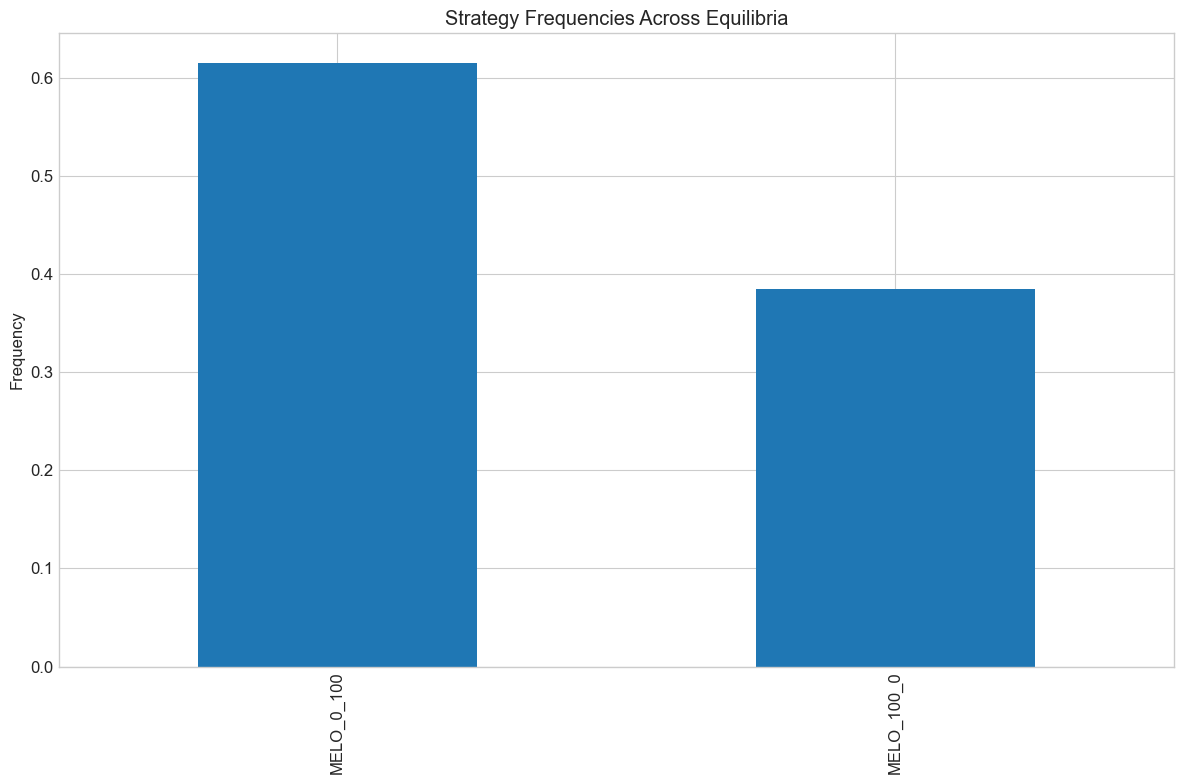

In [17]:
# Print top strategies
print("Top strategies by frequency:")
for strategy, freq in analysis['top_strategies']:
    print(f"  {strategy}: {freq:.4f}")

# Create a bar chart of strategy frequencies
strategy_freqs = pd.Series(analysis['strategy_frequencies'])
strategy_freqs.sort_values(ascending=False).plot(kind='bar')
plt.title('Strategy Frequencies Across Equilibria')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()  

## 4. Visualizing Results

## TODO FIX THIS

In [9]:
# Plot the equilibria as a heatmap
'''
plot_equilibria(
    game=game,
    equilibria=egta.equilibria,
    output_file=os.path.join(output_dir, 'equilibria.png'),
    show=True
)
'''

"\nplot_equilibria(\n    game=game,\n    equilibria=egta.equilibria,\n    output_file=os.path.join(output_dir, 'equilibria.png'),\n    show=True\n)\n"

In [10]:
# Plot strategy frequency
'''
plot_strategy_frequency(
    equilibria=egta.equilibria,
    strategy_names=game.strategy_names,
    output_file=os.path.join(output_dir, 'strategy_frequency.png'),
    show=True
)
'''

"\nplot_strategy_frequency(\n    equilibria=egta.equilibria,\n    strategy_names=game.strategy_names,\n    output_file=os.path.join(output_dir, 'strategy_frequency.png'),\n    show=True\n)\n"

In [11]:
# Plot payoff matrix
''''
plot_payoff_matrix(
    game=game,
    output_file=os.path.join(output_dir, 'payoff_matrix.png'),
    show=True
)
'''

"'\nplot_payoff_matrix(\n    game=game,\n    output_file=os.path.join(output_dir, 'payoff_matrix.png'),\n    show=True\n)\n"

In [12]:
# Plot regret landscapes for pairs of strategies
# This helps visualize where the equilibria are located
''''
if len(game.strategy_names) <= 5:  # Only if we have a manageable number of strategies
    for i in range(len(game.strategy_names)):
        for j in range(i+1, len(game.strategy_names)):
            plot_regret_landscape(
                game=game,
                strategies=[game.strategy_names[i], game.strategy_names[j]],
                resolution=50,  # Reduced resolution for speed
                output_file=os.path.join(output_dir, f'regret_landscape_{i}_{j}.png'),
                show=True
            )
'''

"'\nif len(game.strategy_names) <= 5:  # Only if we have a manageable number of strategies\n    for i in range(len(game.strategy_names)):\n        for j in range(i+1, len(game.strategy_names)):\n            plot_regret_landscape(\n                game=game,\n                strategies=[game.strategy_names[i], game.strategy_names[j]],\n                resolution=50,  # Reduced resolution for speed\n                output_file=os.path.join(output_dir, f'regret_landscape_{i}_{j}.png'),\n                show=True\n            )\n"

In [13]:
# Create a comprehensive visualization report
'''
vis_dir = os.path.join(output_dir, 'visualizations')
report_path = create_visualization_report(
    game=game,
    equilibria=egta.equilibria,
    output_dir=vis_dir
)

print(f"Visualization report saved to {report_path}")
print("Open this HTML file in a browser to view the visualization report")
'''

'\nvis_dir = os.path.join(output_dir, \'visualizations\')\nreport_path = create_visualization_report(\n    game=game,\n    equilibria=egta.equilibria,\n    output_dir=vis_dir\n)\n\nprint(f"Visualization report saved to {report_path}")\nprint("Open this HTML file in a browser to view the visualization report")\n'

## 5. Parameter Sweeps

Now let's explore how different market conditions affect the equilibrium strategies by running parameter sweeps.

In [14]:
def run_experiment(holding_period, lam):
    """Run an EGTA experiment with specific parameters."""
    # Create experiment directory
    exp_dir = f"{output_dir}/sweep_h{holding_period}_lam{lam}"
    os.makedirs(exp_dir, exist_ok=True)
    
    # Create simulator with specific parameters
    simulator = MeloSimulator(
        num_players=10,
        sim_time=1000,
        lam=lam,             # Vary arrival rate
        mean=100,
        r=0.05,
        q_max=10,
        holding_period=holding_period,  # Vary holding period
        reps=2  # Use fewer repetitions for speed
    )
    
    # Create scheduler
    scheduler = DPRScheduler(
        strategies=simulator.get_strategies(),
        num_players=simulator.get_num_players(),
        subgame_size=min(4, len(simulator.get_strategies())),
        batch_size=3,
        seed=42
    )
    
    # Create EGTA framework
    egta = EGTA(
        simulator=simulator,
        scheduler=scheduler,
        device="cpu",
        output_dir=exp_dir,
        max_profiles=30,
        seed=42
    )
    
    # Run with fewer iterations for the parameter sweep
    game = egta.run(
        max_iterations=3,
        profiles_per_iteration=3,
        save_frequency=1,
        verbose=False  # Less verbose for parameter sweep
    )
    
    # Analyze equilibria
    analysis = egta.analyze_equilibria(verbose=False)
    
    # Save analysis
    with open(os.path.join(exp_dir, 'analysis.json'), 'w') as f:
        json.dump(analysis, f, indent=2)
    
    return {
        'holding_period': holding_period,
        'lam': lam,
        'equilibria': [(mix.tolist(), float(reg)) for mix, reg in egta.equilibria],
        'strategy_frequencies': analysis['strategy_frequencies'],
        'top_strategies': analysis['top_strategies']
    }

In [15]:
# Define parameter grid
holding_periods = [1, 5, 10]  # Different MELO holding periods
lambdas = [0.05, 0.1, 0.2]    # Different arrival rates

# Run experiments
results = []
for h in holding_periods:
    print(f"Processing holding period: {h}")
    for lam in lambdas:
        print(f"\nRunning experiment with holding_period={h}, lambda={lam}")
        result = run_experiment(h, lam)
        results.append(result)
        print(f"Completed experiment. Found {len(result['equilibria'])} equilibria.")

# Save all results
with open(os.path.join(output_dir, 'parameter_sweep_results.json'), 'w') as f:
    json.dump(results, f, indent=2)

Processing holding period: 1

Running experiment with holding_period=1, lambda=0.05


TypeError: MeloSimulator.__init__() got an unexpected keyword argument 'num_players'

In [ ]:
sweep_df = pd.DataFrame(results)

def get_top_strategy(row):
    if row['top_strategies']:
        return row['top_strategies'][0][0] 
    return None

sweep_df['top_strategy'] = sweep_df.apply(get_top_strategy, axis=1)

pivot = pd.pivot_table(
    sweep_df, 
    values='top_strategy', 
    index='holding_period', 
    columns='lam',
    aggfunc=lambda x: x
)

print("Top strategy by holding period and arrival rate:")
display(pivot)

plt.figure(figsize=(12, 8))
strategies = simulator.get_strategies()

fig, axes = plt.subplots(len(holding_periods), len(lambdas), figsize=(15, 10))
fig.suptitle('Strategy Frequencies by Market Conditions', fontsize=16)

for i, h in enumerate(holding_periods):
    axes[i, 0].set_ylabel(f'Holding Period = {h}')
    
for j, lam in enumerate(lambdas):
    axes[0, j].set_title(f'λ = {lam}')

for i, h in enumerate(holding_periods):
    for j, lam in enumerate(lambdas):
        result = next((r for r in results if r['holding_period'] == h and r['lam'] == lam), None)
        if result:
            freqs = pd.Series(result['strategy_frequencies'])
            freqs.plot(kind='bar', ax=axes[i, j])
            axes[i, j].set_xticklabels(axes[i, j].get_xticklabels(), rotation=90)
            axes[i, j].set_ylim(0, 1)
            
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(output_dir, 'parameter_sweep_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()

## 6. Advanced EGTA - Custom Strategy Space

Let's explore how to define and analyze a custom strategy space, with more fine-grained allocation proportions.

In [17]:
class CustomMeloSimulator(MeloSimulator):
    """Extended MeloSimulator with custom strategy space."""
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # more fine-grained strategy space
        self.strategies = [
            "MELO_100_0",   # 100% CDA, 0% MELO
            "MELO_90_10",   # 90% CDA, 10% MELO
            "MELO_80_20",   # 80% CDA, 20% MELO
            "MELO_70_30",   # 70% CDA, 30% MELO
            "MELO_60_40",   # 60% CDA, 40% MELO
            "MELO_50_50",   # 50% CDA, 50% MELO
            "MELO_40_60",   # 40% CDA, 60% MELO
            "MELO_30_70",   # 30% CDA, 70% MELO
            "MELO_20_80",   # 20% CDA, 80% MELO
            "MELO_10_90",   # 10% CDA, 90% MELO
            "MELO_0_100",   # 0% CDA, 100% MELO
        ]
        
        # strategy parameters
        self.strategy_params = {}
        for strategy in self.strategies:
            # Parse the strategy name to get proportions
            parts = strategy.split('_')
            cda_prop = int(parts[1]) / 100
            melo_prop = int(parts[2]) / 100
            self.strategy_params[strategy] = {
                "cda_proportion": cda_prop,
                "melo_proportion": melo_prop
            }

In [ ]:
custom_output_dir = f"{output_dir}/custom_strategy_space"
os.makedirs(custom_output_dir, exist_ok=True)

custom_simulator = CustomMeloSimulator(
    num_players=10,
    sim_time=1000,
    lam=0.1,
    holding_period=5,
    reps=2  # Use fewer repetitions for speed
)

#Print available strategies
strategies = custom_simulator.get_strategies()
print(f"Available strategies: {strategies}")

#Print strategy parameters
print("\nStrategy parameters:")
for strategy in strategies:
    params = custom_simulator.strategy_params[strategy]
    print(f"  {strategy}: CDA={params['cda_proportion']:.2f}, MELO={params['melo_proportion']:.2f}")

In [19]:
custom_scheduler = RandomScheduler(
    strategies=strategies,
    num_players=custom_simulator.get_num_players(),
    batch_size=5,
    seed=42
)

custom_egta = EGTA(
    simulator=custom_simulator,
    scheduler=custom_scheduler,
    device="cpu",
    output_dir=custom_output_dir,
    max_profiles=40,
    seed=42
)

In [ ]:
print("Starting EGTA experiment with custom strategy space...")
print(f"Analyzing {len(strategies)} different allocation strategies")

custom_game = custom_egta.run(
    max_iterations=4,
    profiles_per_iteration=5,
    save_frequency=1,
    verbose=True
)

print("\nEGTA experiment completed!")

In [ ]:
custom_analysis = custom_egta.analyze_equilibria(verbose=True)

with open(os.path.join(custom_output_dir, 'analysis.json'), 'w') as f:
    json.dump(custom_analysis, f, indent=2)

In [ ]:
custom_vis_dir = os.path.join(custom_output_dir, 'visualizations')
custom_report_path = create_visualization_report(
    game=custom_game,
    equilibria=custom_egta.equilibria,
    output_dir=custom_vis_dir
)

print(f"Visualization report saved to {custom_report_path}")

## 7. Analysis of Optimal Allocation Curve

## TODO, WE MIGHT want some analysis of metrics, stats. 


In [23]:
def run_holding_period_sweep(holding_periods):
    """Run experiments across different holding periods."""
    sweep_results = []
    
    for holding_period in tqdm(holding_periods):
        # Create experiment directory
        exp_dir = f"{output_dir}/holding_sweep_{holding_period}"
        os.makedirs(exp_dir, exist_ok=True)
        
        # Create simulator with specific holding period
        sim = CustomMeloSimulator(
            num_players=10,
            sim_time=1000,
            lam=0.1,
            holding_period=holding_period,
            reps=2
        )
        
        # Create scheduler
        sched = DPRScheduler(
            strategies=sim.get_strategies(),
            num_players=sim.get_num_players(),
            subgame_size=5,  # Use a larger subgame size for more exploration
            batch_size=4,
            seed=42
        )
        
        # Create EGTA framework
        egta_instance = EGTA(
            simulator=sim,
            scheduler=sched,
            device="cpu",
            output_dir=exp_dir,
            max_profiles=30,
            seed=42
        )
        
        # Run EGTA
        game = egta_instance.run(
            max_iterations=3,
            profiles_per_iteration=4,
            save_frequency=1,
            verbose=False
        )
        
        # Analyze equilibria
        analysis = egta_instance.analyze_equilibria(verbose=False)
        
        # Extract CDA proportions from top strategies
        cda_proportions = []
        for eq_mix, _ in egta_instance.equilibria:
            eq_strat_freqs = dict(zip(game.strategy_names, eq_mix.tolist()))
            weighted_cda_prop = 0
            for strat, freq in eq_strat_freqs.items():
                if freq > 0.01:  # Only count strategies with significant probability
                    cda_prop = sim.strategy_params[strat]['cda_proportion']
                    weighted_cda_prop += cda_prop * freq
            cda_proportions.append(weighted_cda_prop)
        
        # Calculate average CDA proportion
        avg_cda_prop = np.mean(cda_proportions) if cda_proportions else None
        
        # Save results
        result = {
            'holding_period': holding_period,
            'avg_cda_proportion': avg_cda_prop,
            'cda_proportions': cda_proportions,
            'num_equilibria': len(egta_instance.equilibria),
            'top_strategies': analysis['top_strategies']
        }
        sweep_results.append(result)
        
    return sweep_results

In [ ]:
# Run a sweep across different holding periods
holding_periods = [1, 2, 3, 5, 7, 10, 15, 20]
holding_sweep_results = run_holding_period_sweep(holding_periods)

# Save results
with open(os.path.join(output_dir, 'holding_period_sweep_results.json'), 'w') as f:
    json.dump(holding_sweep_results, f, indent=2)

In [ ]:
# Create a dataframe from results
holding_df = pd.DataFrame(holding_sweep_results)

# Plot the relationship between holding period and CDA proportion
plt.figure(figsize=(10, 6))
plt.plot(holding_df['holding_period'], holding_df['avg_cda_proportion'], 'o-', linewidth=2, markersize=8)
plt.xlabel('MELO Holding Period')
plt.ylabel('Average CDA Proportion in Equilibrium')
plt.title('Optimal CDA Allocation vs. MELO Holding Period')
plt.grid(True)
plt.ylim(0, 1)
plt.savefig(os.path.join(output_dir, 'optimal_allocation_curve.png'), dpi=300, bbox_inches='tight')
plt.show()

# Display the data
display(holding_df[['holding_period', 'avg_cda_proportion', 'num_equilibria']])